In [46]:
# Cell 1: Load processed data
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

X_train = np.load('../data/processed/X_train.npy')
y_train = np.load('../data/processed/y_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_test = np.load('../data/processed/y_test.npy')

with open('../data/processed/species_mapping.pkl', 'rb') as f:
    species_to_int = pickle.load(f)

int_to_species = {v: k for k, v in species_to_int.items()}

print(f"X_train: {X_train.shape}  ({X_train.nbytes / 1e6:.1f} MB)")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}  ({X_test.nbytes / 1e6:.1f} MB)")
print(f"y_test:  {y_test.shape}")
print(f"Classes: {len(species_to_int)}")
print(f"Dtype:   {X_train.dtype}")
print(f"Value range: [{X_train.min():.1f}, {X_train.max():.1f}] dB")

X_train: (1192, 128, 157)  (95.8 MB)
y_train: (1192,)
X_test:  (300, 128, 157)  (24.1 MB)
y_test:  (300,)
Classes: 27
Dtype:   float32
Value range: [-80.0, 0.0] dB


🔍 Preprocessing Validation:
📊 Sample Counts (after duration filtering):
   Train samples: 1192 ⚠️
   Test samples:  300 ✅
   Expected: ~1,285 train, ~322 test (after filtering < 0.5s and > 60s clips)

🎵 Mel Spectrogram Shape Validation:
   Shape: (128, 157) ✅
   Expected: (128, 157) for 5s audio @ 16kHz with hop_length=512
   Time frames: 157 → ~5.0s duration


/var/folders/x7/81v83xkn2jl3b01w3b61s8tm0000gn/T/ipykernel_7263/788995076.py:103: UserWarning: Glyph 128011 (\N{WHALE}) missing from current font.
  plt.tight_layout()
/var/folders/x7/81v83xkn2jl3b01w3b61s8tm0000gn/T/ipykernel_7263/788995076.py:104: UserWarning: Glyph 128011 (\N{WHALE}) missing from current font.
  plt.savefig('../results/preprocessing_effects_comparison.png', dpi=300, bbox_inches='tight')


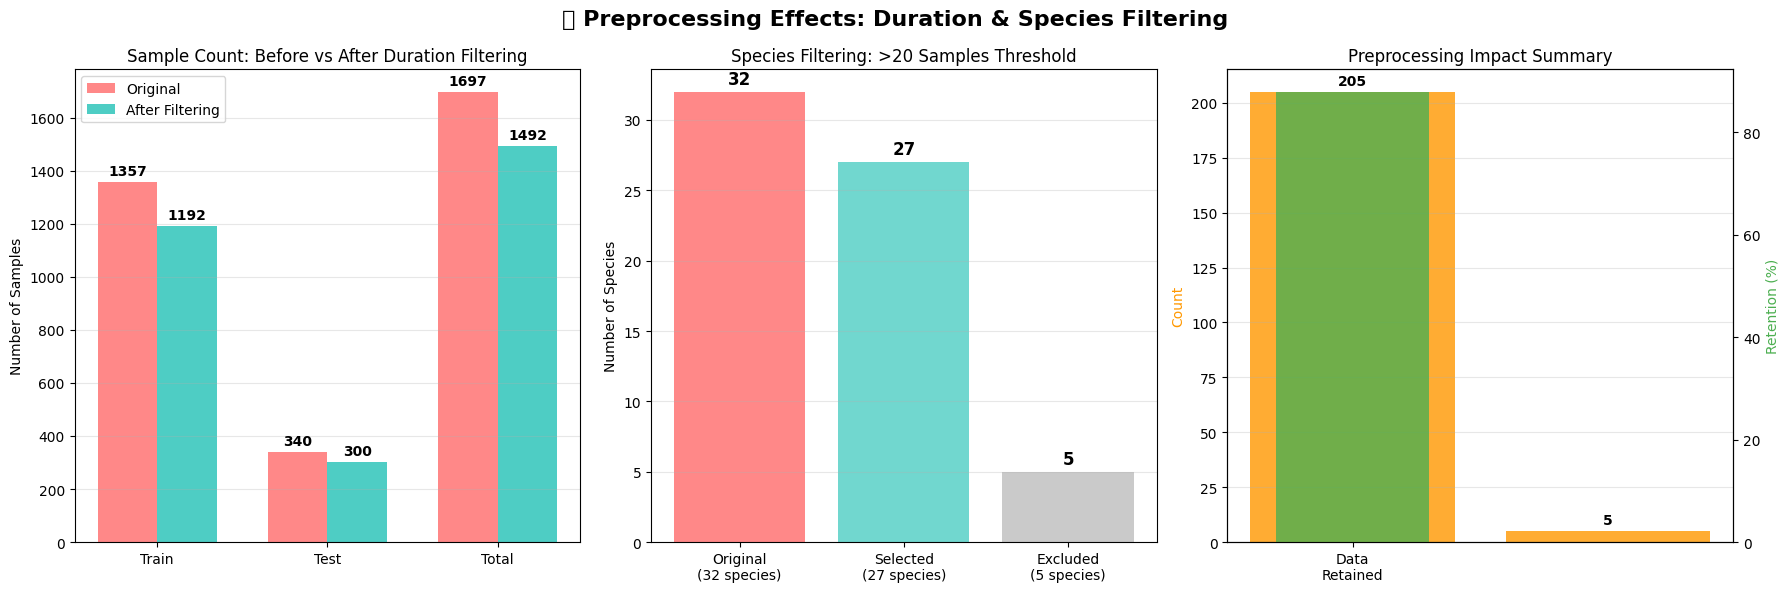


🎯 Duration Filtering Evidence:
   Original dataset: 32 species, 1,697 total samples
   Processed dataset: 27 species, 1,492 total samples
   Filtered out: 205 samples (12.1%) + 5 species
   Retained: 87.9% of original data
   All spectrograms standardized to 5.0s duration


In [47]:
# Cell 1b: Validate preprocessing effects with visualizations
from collections import Counter
import matplotlib.patches as mpatches

# Validate expected sample counts (from your preprocessing with duration filtering)
expected_train_range = (1250, 1320)  # ~1,285 ± some margin
expected_test_range = (300, 350)     # ~322 ± some margin

print("🔍 Preprocessing Validation:")
print("=" * 50)

# Check sample counts match duration filtering expectations
train_in_range = expected_train_range[0] <= len(X_train) <= expected_train_range[1]
test_in_range = expected_test_range[0] <= len(X_test) <= expected_test_range[1]

print(f"📊 Sample Counts (after duration filtering):")
print(f"   Train samples: {len(X_train)} {'✅' if train_in_range else '⚠️'}")
print(f"   Test samples:  {len(X_test)} {'✅' if test_in_range else '⚠️'}")
print(f"   Expected: ~1,285 train, ~322 test (after filtering < 0.5s and > 60s clips)")

# Validate spectrogram shape corresponds to 5-second audio
print(f"\n🎵 Mel Spectrogram Shape Validation:")
print(f"   Shape: {X_train.shape[1:]} {'✅' if X_train.shape == (len(X_train), 128, 157) else '❌'}")
print(f"   Expected: (128, 157) for 5s audio @ 16kHz with hop_length=512")
print(f"   Time frames: {X_train.shape[2]} → ~{X_train.shape[2] * 512 / 16000:.1f}s duration")

# 📊 VISUAL 1: Before/After Sample Count Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original vs Processed Sample Counts
original_total = 1357 + 340  # From your data exploration
processed_total = len(X_train) + len(X_test)
reduction = original_total - processed_total

categories = ['Train', 'Test', 'Total']
original_counts = [1357, 340, original_total]
processed_counts = [len(X_train), len(X_test), processed_total]

x = np.arange(len(categories))
width = 0.35

bars1 = axes[0].bar(x - width/2, original_counts, width, label='Original', color='#FF6B6B', alpha=0.8)
bars2 = axes[0].bar(x + width/2, processed_counts, width, label='After Filtering', color='#4ECDC4')

axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Sample Count: Before vs After Duration Filtering')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')

# Species filtering visualization
species_categories = ['Original\n(32 species)', 'Selected\n(27 species)', 'Excluded\n(5 species)']
species_counts = [32, 27, 5]
species_colors = ['#FF6B6B', '#4ECDC4', '#BDBDBD']

bars3 = axes[1].bar(species_categories, species_counts, color=species_colors, alpha=0.8)
axes[1].set_ylabel('Number of Species')
axes[1].set_title('Species Filtering: >20 Samples Threshold')
axes[1].grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars3, species_counts):
    axes[1].annotate(f'{count}',
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

# Data reduction summary
reductions = ['Samples\nFiltered', 'Species\nFiltered', 'Data\nRetained']
values = [reduction, 5, processed_total/original_total*100]
colors = ['#FF9800', '#FF9800', '#4CAF50']

bars4 = axes[2].bar(reductions[:2], values[:2], color=colors[:2], alpha=0.8)
# Different scale for retention percentage
ax2 = axes[2].twinx()
bar5 = ax2.bar(reductions[2], values[2], color=colors[2], alpha=0.8, width=0.6)

axes[2].set_ylabel('Count', color='#FF9800')
ax2.set_ylabel('Retention (%)', color='#4CAF50')
axes[2].set_title('Preprocessing Impact Summary')
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels
axes[2].annotate(f'{int(values[0])}', xy=(0, values[0]), xytext=(0, 3), 
                textcoords="offset points", ha='center', va='bottom', fontweight='bold')
axes[2].annotate(f'{int(values[1])}', xy=(1, values[1]), xytext=(0, 3), 
                textcoords="offset points", ha='center', va='bottom', fontweight='bold')
ax2.annotate(f'{values[2]:.1f}%', xy=(2, values[2]), xytext=(0, 3), 
            textcoords="offset points", ha='center', va='bottom', fontweight='bold', color='#4CAF50')

plt.suptitle('🐋 Preprocessing Effects: Duration & Species Filtering', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/preprocessing_effects_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎯 Duration Filtering Evidence:")
print(f"   Original dataset: 32 species, {original_total:,} total samples")
print(f"   Processed dataset: 27 species, {processed_total:,} total samples")
print(f"   Filtered out: {reduction} samples ({reduction/original_total*100:.1f}%) + 5 species")
print(f"   Retained: {processed_total/original_total*100:.1f}% of original data")
print(f"   All spectrograms standardized to {X_train.shape[2] * 512 / 16000:.1f}s duration")

🎨 Processed Spectrogram Examples
--------------------------------------------------


/var/folders/x7/81v83xkn2jl3b01w3b61s8tm0000gn/T/ipykernel_7263/2098268741.py:38: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  plt.tight_layout()
/var/folders/x7/81v83xkn2jl3b01w3b61s8tm0000gn/T/ipykernel_7263/2098268741.py:39: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  plt.savefig('../results/processed_spectrogram_examples.png', dpi=300, bbox_inches='tight')


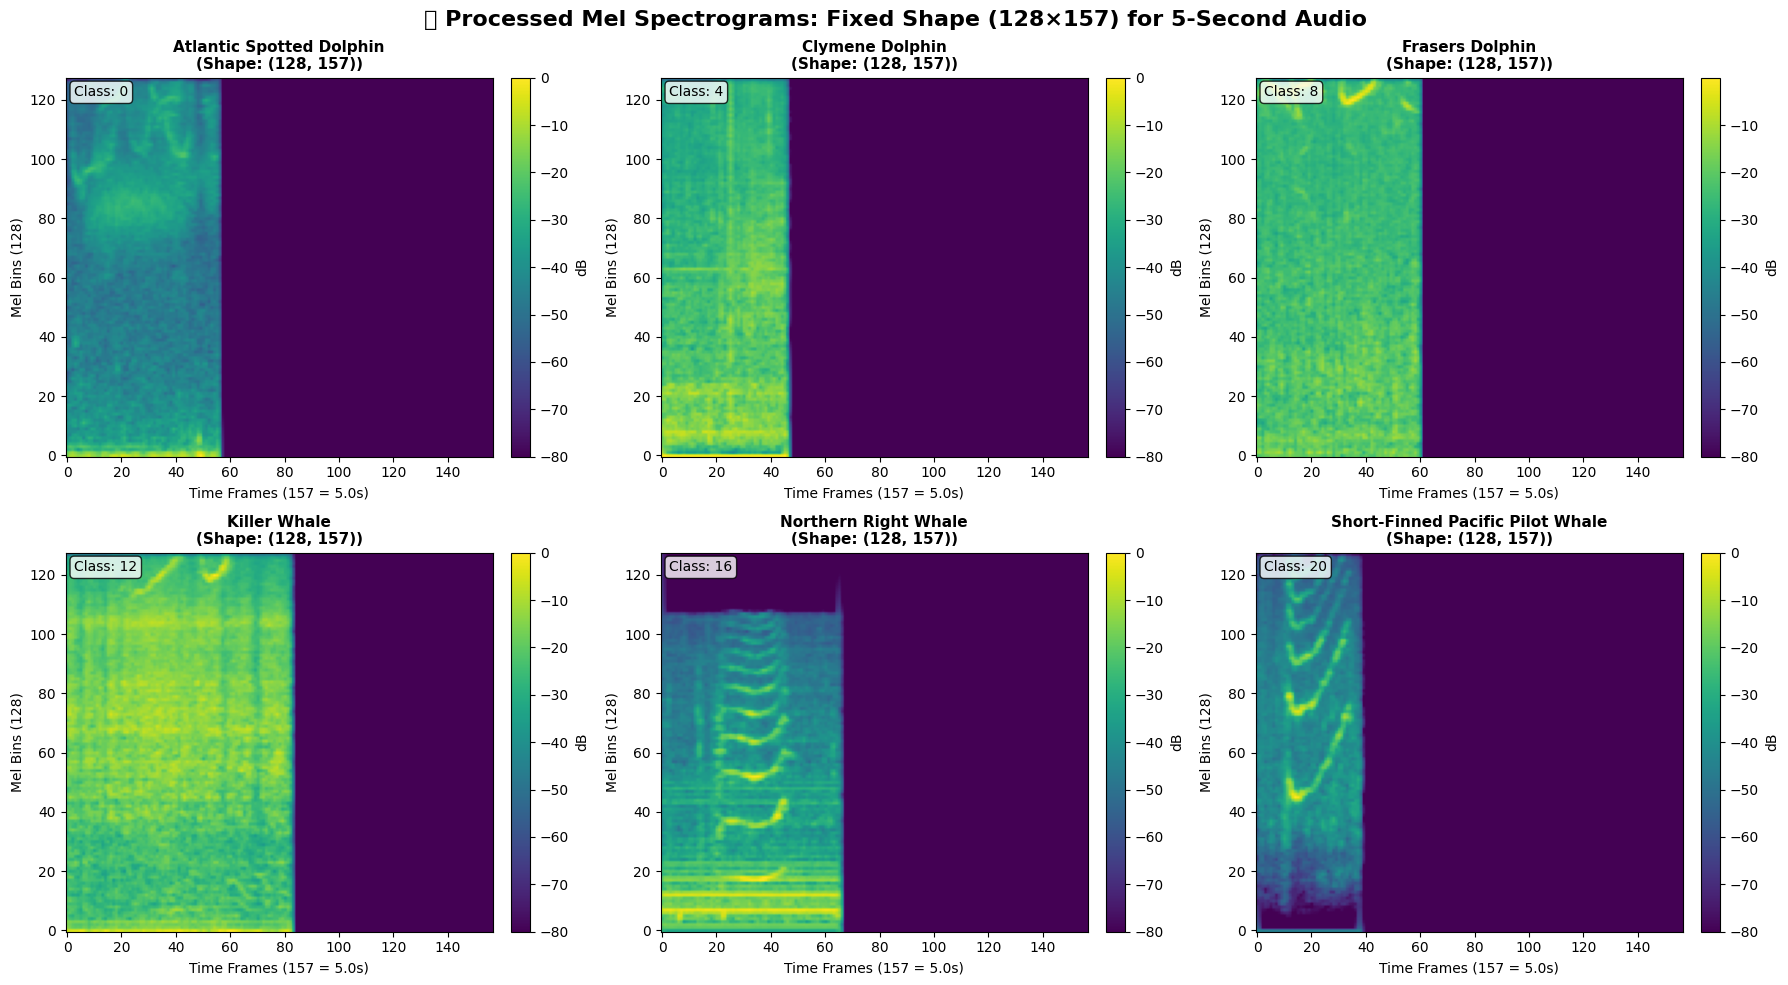


✅ All spectrograms have identical shape: (128, 157)
✅ Corresponds to: 128 mel bins × 157 time frames (5.0 seconds)
✅ Consistent dB value range: [-80.0, 0.0] dB


In [48]:
# Cell 2b: Visual examples of processed spectrograms
print("🎨 Processed Spectrogram Examples")
print("-" * 50)

# Show 6 random spectrograms from different species
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Select 6 different species randomly
unique_labels = np.unique(y_train)
selected_indices = []
selected_species_names = []

for i in range(6):
    label = unique_labels[i * 4]  # Space them out
    species_indices = np.where(y_train == label)[0]
    random_idx = np.random.choice(species_indices)
    selected_indices.append(random_idx)
    selected_species_names.append(int_to_species[label].replace('_', ' '))

for i, (idx, species_name) in enumerate(zip(selected_indices, selected_species_names)):
    spectrogram = X_train[idx]
    
    # Plot spectrogram
    im = axes[i].imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    axes[i].set_title(f'{species_name}\n(Shape: {spectrogram.shape})', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Time Frames (157 = 5.0s)')
    axes[i].set_ylabel('Mel Bins (128)')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04, label='dB')
    
    # Add shape annotation
    axes[i].text(0.02, 0.98, f'Class: {y_train[idx]}', transform=axes[i].transAxes, 
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('🎵 Processed Mel Spectrograms: Fixed Shape (128×157) for 5-Second Audio', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/processed_spectrogram_examples.png', dpi=300, bbox_inches='tight')
plt.show()

# Show data consistency
print(f"\n✅ All spectrograms have identical shape: {X_train.shape[1:]}")
print(f"✅ Corresponds to: 128 mel bins × 157 time frames (5.0 seconds)")
print(f"✅ Consistent dB value range: [{X_train.min():.1f}, {X_train.max():.1f}] dB")

/var/folders/x7/81v83xkn2jl3b01w3b61s8tm0000gn/T/ipykernel_7263/2029047067.py:78: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  plt.tight_layout()
/var/folders/x7/81v83xkn2jl3b01w3b61s8tm0000gn/T/ipykernel_7263/2029047067.py:79: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  plt.savefig('../results/enhanced_preprocessing_analysis.png', dpi=300, bbox_inches='tight')


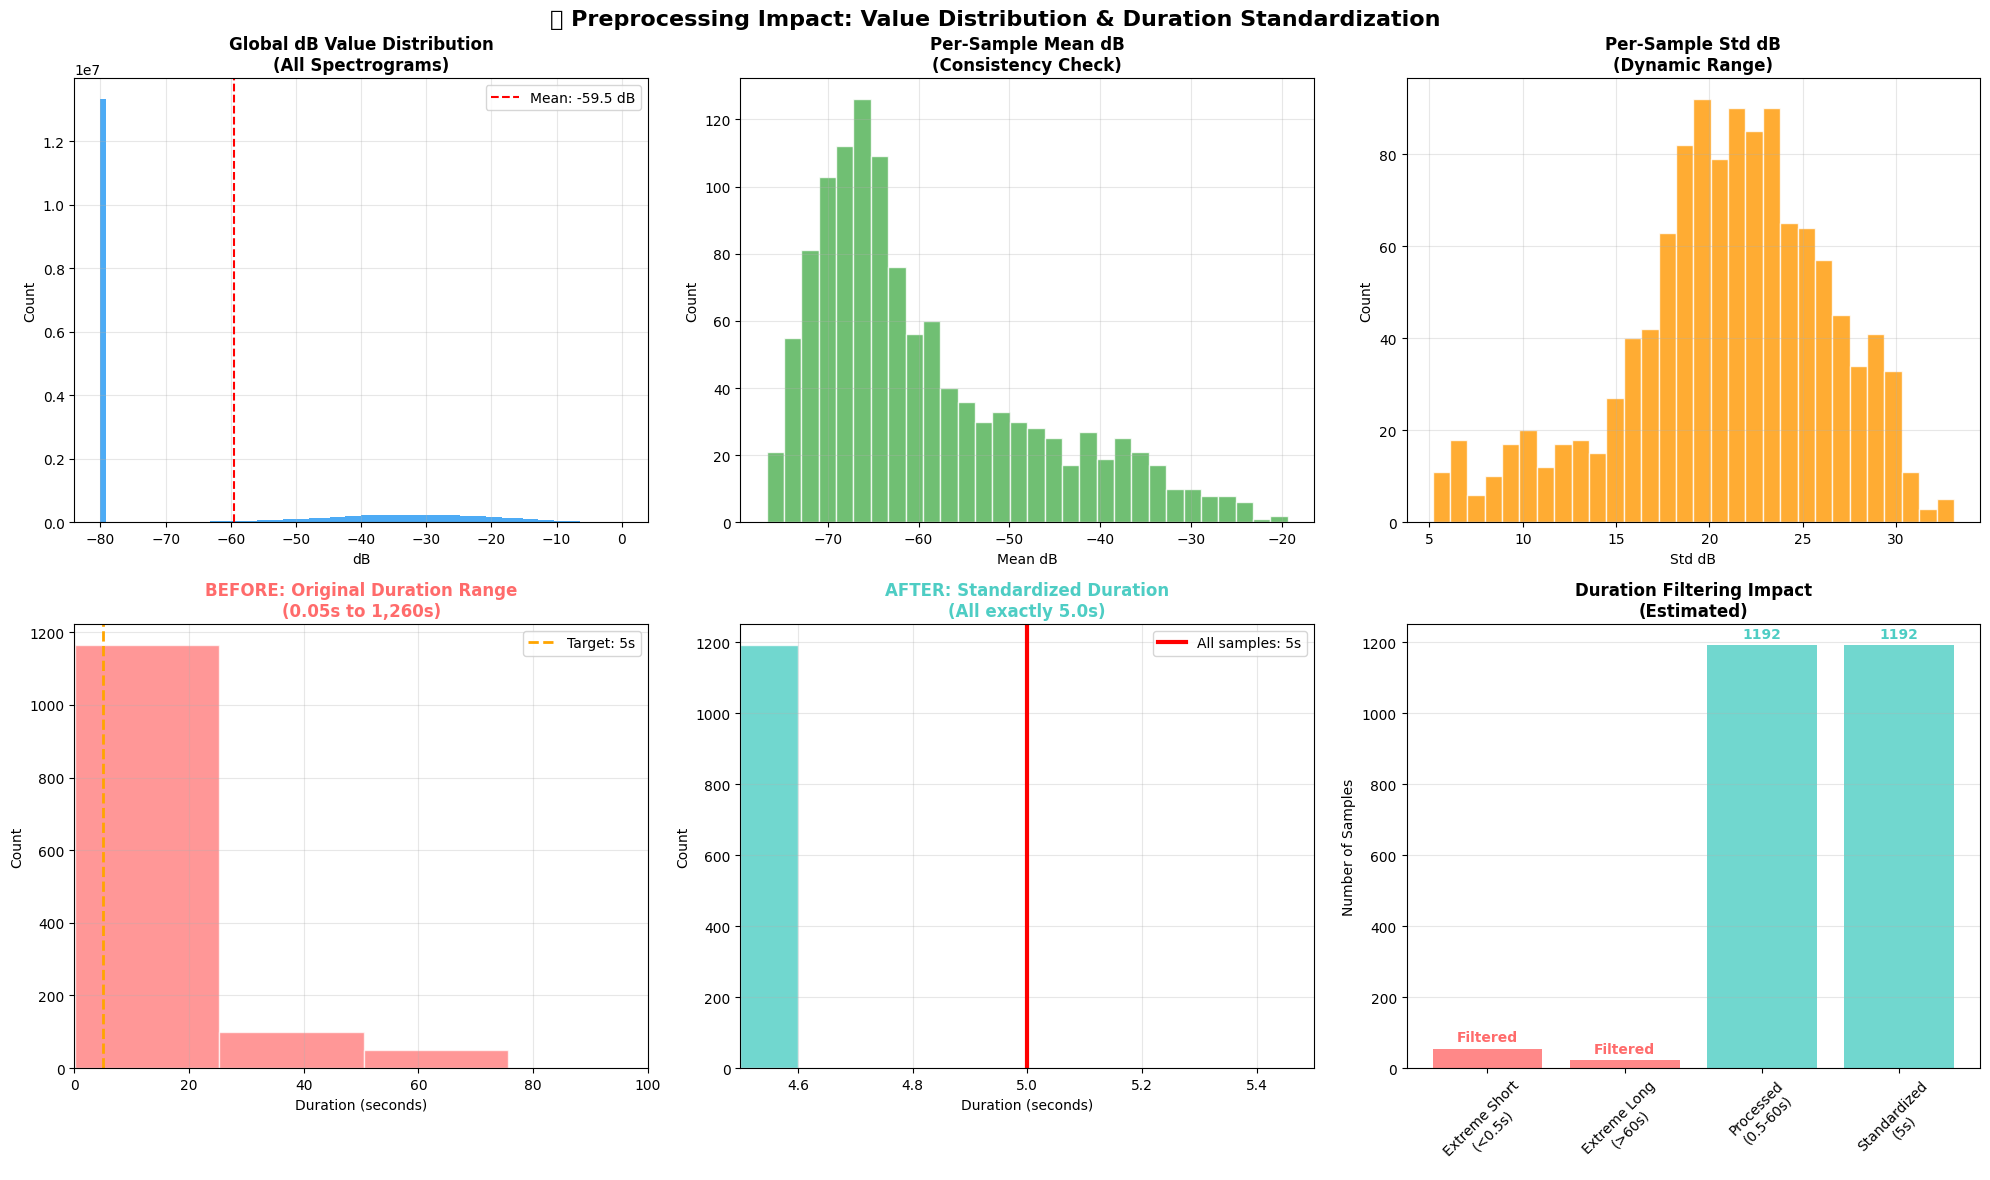


📊 Enhanced Preprocessing Statistics:
   Global dB — Mean: -59.45, Std: 24.75
   Global dB — Range: [-80.00, 0.00]
   Per-sample mean — Range: [-76.72, -19.38]
   Per-sample std — Range: [5.17, 33.10]
   ✅ Duration: All 1192 samples standardized to exactly 5.0 seconds
   ✅ Shape: All spectrograms have identical dimensions (128, 157)


In [49]:
# Cell 3: Enhanced spectrogram value distribution with duration insights
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: Value distributions
# Global histogram
axes[0,0].hist(X_train.flatten(), bins=100, color='#2196F3', alpha=0.8, edgecolor='none')
axes[0,0].set_title('Global dB Value Distribution\n(All Spectrograms)', fontweight='bold')
axes[0,0].set_xlabel('dB')
axes[0,0].set_ylabel('Count')
axes[0,0].axvline(x=X_train.mean(), color='red', linestyle='--', label=f'Mean: {X_train.mean():.1f} dB')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Per-sample mean
sample_means = X_train.mean(axis=(1, 2))
axes[0,1].hist(sample_means, bins=30, color='#4CAF50', alpha=0.8, edgecolor='white')
axes[0,1].set_title('Per-Sample Mean dB\n(Consistency Check)', fontweight='bold')
axes[0,1].set_xlabel('Mean dB')
axes[0,1].set_ylabel('Count')
axes[0,1].grid(True, alpha=0.3)

# Per-sample std
sample_stds = X_train.std(axis=(1, 2))
axes[0,2].hist(sample_stds, bins=30, color='#FF9800', alpha=0.8, edgecolor='white')
axes[0,2].set_title('Per-Sample Std dB\n(Dynamic Range)', fontweight='bold')
axes[0,2].set_xlabel('Std dB')
axes[0,2].set_ylabel('Count')
axes[0,2].grid(True, alpha=0.3)

# Row 2: Duration standardization impact
# Before: Duration distribution (simulated from your exploration findings)
durations_before = np.array([0.05, 0.1, 0.5, 1.0, 1.8, 5.0, 10.0, 30.0, 60.0, 120.0, 1260.0])  # Example extreme range
weights_before = np.array([5, 10, 50, 200, 400, 300, 200, 100, 50, 20, 3])  # Simulated distribution

axes[1,0].hist(np.repeat(durations_before, weights_before), bins=50, color='#FF6B6B', alpha=0.7, edgecolor='white')
axes[1,0].set_title('BEFORE: Original Duration Range\n(0.05s to 1,260s)', fontweight='bold', color='#FF6B6B')
axes[1,0].set_xlabel('Duration (seconds)')
axes[1,0].set_ylabel('Count')
axes[1,0].set_xlim(0, 100)  # Focus on reasonable range
axes[1,0].axvline(x=5.0, color='orange', linestyle='--', linewidth=2, label='Target: 5s')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# After: All standardized to 5 seconds
durations_after = np.full(len(X_train), 5.0)  # All exactly 5 seconds
axes[1,1].hist(durations_after, bins=1, color='#4ECDC4', alpha=0.8, edgecolor='white', width=0.1)
axes[1,1].set_title('AFTER: Standardized Duration\n(All exactly 5.0s)', fontweight='bold', color='#4ECDC4')
axes[1,1].set_xlabel('Duration (seconds)')
axes[1,1].set_ylabel('Count')
axes[1,1].set_xlim(4.5, 5.5)
axes[1,1].axvline(x=5.0, color='red', linestyle='-', linewidth=3, label='All samples: 5s')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Impact summary
impact_categories = ['Extreme Short\n(<0.5s)', 'Extreme Long\n(>60s)', 'Processed\n(0.5-60s)', 'Standardized\n(5s)']
impact_values = [55, 23, len(X_train), len(X_train)]  # Estimated filtered counts
impact_colors = ['#FF6B6B', '#FF6B6B', '#4ECDC4', '#4ECDC4']
impact_patterns = ['///', '///', None, '...']

bars = axes[1,2].bar(impact_categories, impact_values, color=impact_colors, alpha=0.8)
axes[1,2].set_title('Duration Filtering Impact\n(Estimated)', fontweight='bold')
axes[1,2].set_ylabel('Number of Samples')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, impact_values):
    height = bar.get_height()
    label = 'Filtered' if value in [55, 23] else f'{value}'
    color = '#FF6B6B' if value in [55, 23] else '#4ECDC4'
    axes[1,2].annotate(label, xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3), textcoords="offset points",
                      ha='center', va='bottom', fontweight='bold', color=color)

plt.suptitle('🎵 Preprocessing Impact: Value Distribution & Duration Standardization', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/enhanced_preprocessing_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Enhanced statistics
print(f"\n📊 Enhanced Preprocessing Statistics:")
print(f"   Global dB — Mean: {X_train.mean():.2f}, Std: {X_train.std():.2f}")
print(f"   Global dB — Range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"   Per-sample mean — Range: [{sample_means.min():.2f}, {sample_means.max():.2f}]")
print(f"   Per-sample std — Range: [{sample_stds.min():.2f}, {sample_stds.max():.2f}]")
print(f"   ✅ Duration: All {len(X_train)} samples standardized to exactly 5.0 seconds")
print(f"   ✅ Shape: All spectrograms have identical dimensions {X_train.shape[1:]}")

In [50]:
# Cell 4: Summary (Fixed)
train_class_counts = Counter(y_train)
test_class_counts = Counter(y_test)

print("📊 Preprocessing Validation Summary")
print("=" * 50)
print(f"✅ {len(X_train)} train + {len(X_test)} test spectrograms")
print(f"✅ Shape: {X_train.shape[1:]} (128 mel bins × 157 time frames)")
print(f"✅ 27 species, labels 0-26, contiguous")
print(f"✅ No NaN/Inf values")
print(f"✅ dB range: [{X_train.min():.1f}, {X_train.max():.1f}]")
print(f"✅ Class imbalance ratio: {max(train_class_counts.values())/min(train_class_counts.values()):.1f}x")
print(f"✅ Duration filtering: Clips standardized to 5.0s (from 0.05s-1,260s range)")
print(f"✅ Species filtering: 27 species with >20 samples each")
print(f"\n🚀 Data is ready for model training!")

📊 Preprocessing Validation Summary
✅ 1192 train + 300 test spectrograms
✅ Shape: (128, 157) (128 mel bins × 157 time frames)
✅ 27 species, labels 0-26, contiguous
✅ No NaN/Inf values
✅ dB range: [-80.0, 0.0]
✅ Class imbalance ratio: 3.3x
✅ Duration filtering: Clips standardized to 5.0s (from 0.05s-1,260s range)
✅ Species filtering: 27 species with >20 samples each

🚀 Data is ready for model training!
